# Pysindy with DEC data

In [161]:
import dctkit as dt
from dctkit import config
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from dctkit.mesh import util
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.dec import cochain as C
from dctkit.dec.vector import flat_PDP as flat
from matplotlib import cm
import pysindy as ps
from alpine.data.util import load_dataset
from alpine.data.burgers.burgers_dataset import data_path

In [162]:
config()

In [163]:
# SPACE PARAMS
L = 5.05
L_norm = 1
# spatial resolution
dx = 0.05
#  Number of spatial grid points
num_x_points = int(-(-L // dx))
num_x_points_norm = num_x_points

# vector containing spatial points
x = np.linspace(0, L, num_x_points)
x_circ = (x[:-1] + x[1:])/2

# initial velocity
u_0 = 2 * np.exp(-2 * (x_circ - 0.5 * L)**2)
umax = np.max(u_0)

# TIME PARAMS
T = 2
T_norm = T*umax/L
# temporal resolution
dt = 0.01
dt_norm = dt*umax/L
# number of temporal grid points
num_t_points_norm = int(-(-T_norm // dt_norm))

t = np.linspace(0, T_norm, num_t_points_norm)

In [164]:
# generate mesh
mesh, _ = util.generate_line_mesh(num_x_points_norm, L_norm)
S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_PDP_weights()
# get circ
circ = S.circ[1][:,0]

In [165]:
# load data
time_train, time_val, time_test, u_train_T, u_val_T, u_test_T = load_dataset(
    data_path, "npy")

In [166]:
# reconstruct full data (only for plot)
full_u_data_T = np.zeros((num_t_points_norm, num_x_points_norm-1))
full_u_data_T[time_train] = u_train_T
full_u_data_T[time_val] = u_val_T
full_u_data_T[time_test] = u_test_T

In [167]:
u = full_u_data_T.T
u_dot_true = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

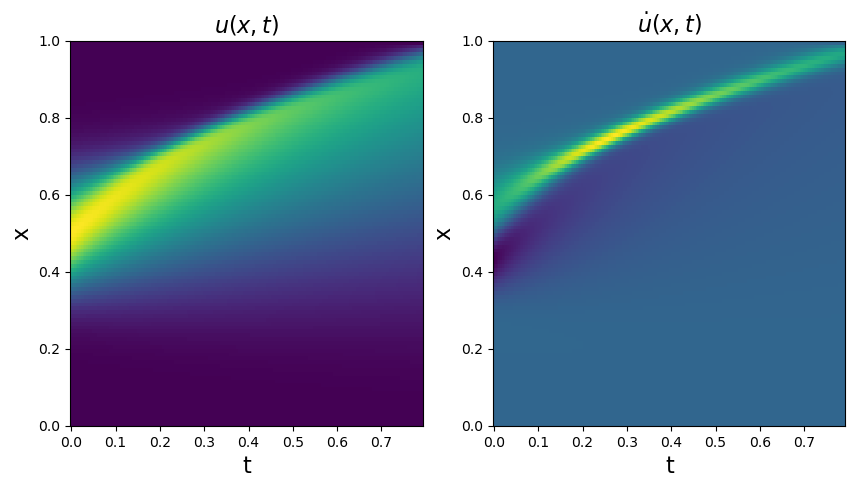

In [168]:
# PLOT FULL DATA
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t, circ, u)
ax[1].pcolormesh(t,circ,u_dot_true)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

## Training

In [169]:
# define u_training
training_time = np.concatenate((time_train, time_val))

# sort times in the correct order
train_sort_map = np.argsort(training_time)
training_time_ord = training_time[train_sort_map]
t_training = t[training_time_ord]

u_training_unordered = np.vstack((u_train_T, u_val_T)).T
# sort u_training w.r.t. times
u_training = u_training_unordered[:, train_sort_map]

# define u_training_dot
#u_dot_training_true = u_dot_true[:, training_time_ord]
u_dot_training_true = ps.FiniteDifference(axis=1)._differentiate(u_training, t=t_training)

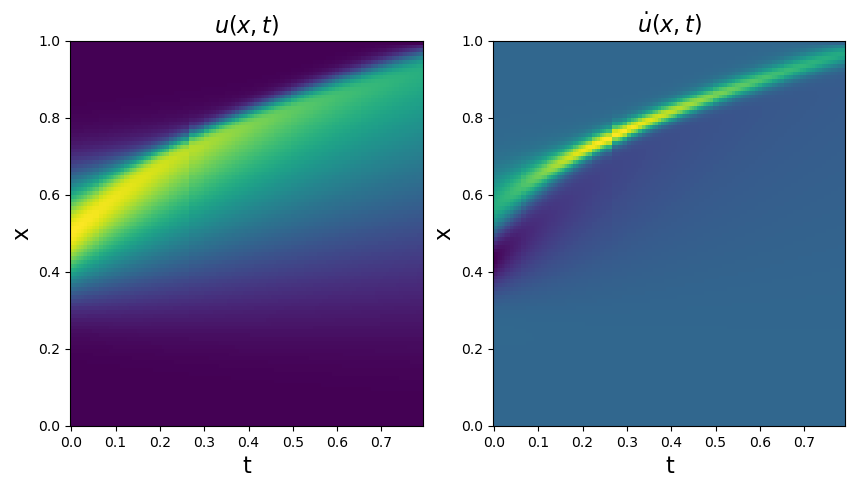

In [170]:
# PRINT TRAINING DATA
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t_training, circ, u_training)
ax[1].pcolormesh(t_training,circ,u_dot_training_true)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

In [171]:
# reshape u_training and u_dot_training
u_training_reshape = u_training.reshape(len(circ), len(training_time), 1)
u_training_dot_reshape = u_dot_training_true.reshape(u_dot_training_true.shape[0], 
                                                     u_dot_training_true.shape[1], 1)

In [172]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=5,
    spatial_grid=circ,
    is_uniform=True,
)

optimizer = ps.STLSQ(threshold=2, alpha=1e-4, normalize_columns=True, verbose=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)

In [173]:
# fit without u_t
print('STLSQ model:')
model.fit(u_training_reshape, t=dt_norm)
model.print()

STLSQ model:
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 7.2367e+03 ... 8.1794e+00 ...         16 ... 7.2448e+03
         1 ... 7.2367e+03 ... 8.1791e+00 ...         16 ... 7.2448e+03
(x0)' = -0.535 x0x0 + 0.033 x0_1 + 0.007 x0_11 + -1.330 x0x0_1 + 0.268 x0x0x0_1 + -0.003 x0x0_11 + -0.006 x0x0x0_11


In [142]:
# fit with u_t
print('STLSQ model:')
model.fit(u_training_reshape, t=dt_norm, x_dot =u_training_dot_reshape)
model.print()

STLSQ model:
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.6442e+01 ... 3.5886e+00 ...         14 ... 2.0031e+01
         1 ... 5.4264e+00 ... 3.6746e+00 ...         13 ... 9.1010e+00
         2 ... 9.1226e+00 ... 3.6742e+00 ...         12 ... 1.2797e+01
         3 ... 5.4703e+00 ... 3.6794e+00 ...         12 ... 9.1497e+00
(x0)' = -0.084 x0 + 0.077 x0x0 + -0.006 x0_1 + 0.005 x0_11 + -0.943 x0x0_1 + -0.046 x0x0x0_1 + -0.002 x0x0x0_11


In [174]:
# compute training error
u_dot_training = model.predict(u_training_reshape)[:,:,0]
print(np.mean(np.linalg.norm(u_dot_training_true - u_dot_training, axis=0)**2))

15.052840320348952


## Test

In [175]:
test_sort_map = np.argsort(time_test)
test_time_ordered = time_test[test_sort_map]

u_test = u_test_T.T[:, test_sort_map]
u_test_reshape = u_test.reshape(u_test.shape[0], u_test.shape[1], 1)

In [176]:
# define u_dot_test_true
t_test = t[test_time_ordered]
u_dot_test_true = ps.FiniteDifference(axis=1)._differentiate(u_test, t=t_test)
# compute test prediction for u_dot
u_dot_test = model.predict(u_test_reshape)[:,:,0]

In [184]:
# compute test error
print(np.mean(np.linalg.norm(u_dot_test_true - u_dot_test, axis=0)**2))

21.041801099163564


## True $\dot{u}$ vs computed $\dot{u}$

In [178]:
# reconstruct u_dot 
u_dot = np.zeros_like(u_dot_true)

u_dot[:, training_time_ord] = u_dot_training
u_dot[:, test_time_ordered] = u_dot_test

In [179]:
# reconstruct u_dot_true_model
u_dot_true_model = np.zeros_like(u_dot_true)

u_dot_true_model[:, training_time_ord] = u_dot_training_true
u_dot_true_model[:, test_time_ordered] = u_dot_test_true

In [180]:
# compute total error
print(np.mean(np.linalg.norm(u_dot_true_model - u_dot, axis=0)**2))

16.250632476111875


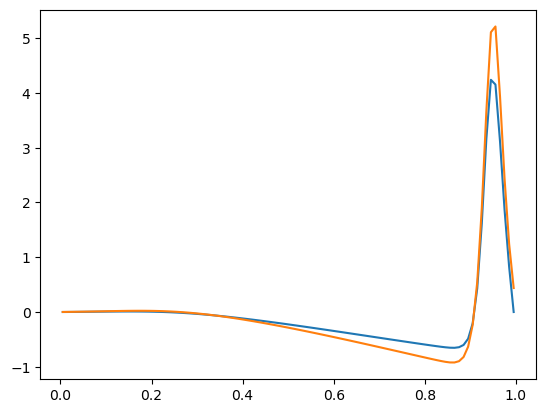

In [181]:
# COMPARISON udot_true VS udot_predict 
# check u_dot profile in the last test time
last_test_time = test_time_ordered[-1]
plt.plot(circ, u_dot_true_model[:,last_test_time])
plt.plot(circ, u_dot[:,last_test_time])
plt.show()

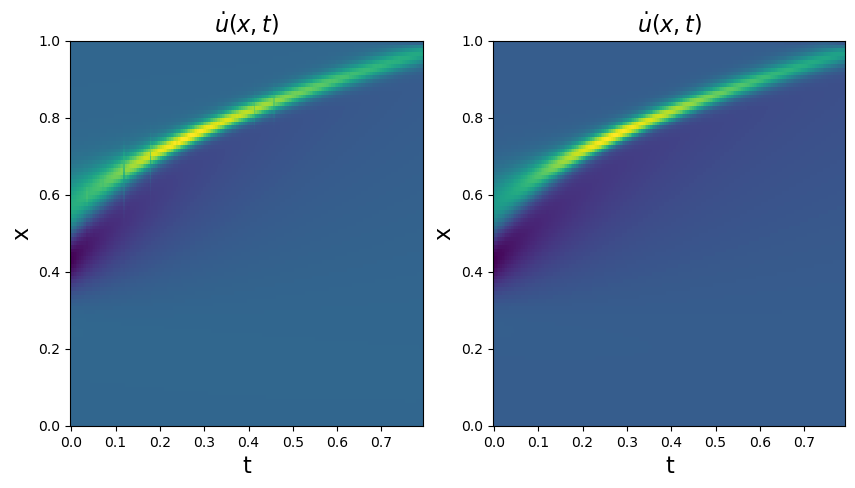

In [182]:
# COMPARISON udot_true VS udot_predict 
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t, circ, u_dot_true_model)
ax[1].pcolormesh(t,circ,u_dot)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$\dot{u}(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()